In [21]:
import re
import unicodedata
import pandas as pd
import nltk
import acquire
import matplotlib.pyplot as plt

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'
    

In [ ]:
spam = pd.read_csv('spam.csv')

In [ ]:
spam.columns

In [ ]:
spam.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [ ]:
spam.rename(columns={'v1':'label','v2':'text'}, inplace=True)

In [ ]:
spam

In [6]:
ADDITIONAL_STOPWORDS = ['r','u','2','ltgt']

def clean(text):
    # Create lemmatizer object
    wnl = nltk.stem.WordNetLemmatizer()
    # Create list of stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
           .encode('ascii','ignore')
           .decode('utf-8','ignore')
           .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [ ]:
labels = pd.concat([spam.label.value_counts(),
                   spam.label.value_counts(normalize=True)], axis =1)
labels.columns = ['n', 'percent']
labels

In [ ]:
ham_words = clean(' '.join(spam[spam.label == 'ham'].text))
spam_words = clean(' '.join(spam[spam.label == 'spam'].text))
all_words = clean(' '.join(spam.text))

In [ ]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

In [ ]:
pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)

In [ ]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
              .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
              .fillna(0) 
              .apply(lambda s: s.astype(int)))

word_counts

### What are the most frequently occuring words?

In [ ]:
word_counts.sort_values(by='all', ascending=False)

### Are there any words that uniquely identify a spam or ham message?

In [ ]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
          word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])

## Visualization

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# figure out the percentage of spam vs ham
(word_counts
.assign(p_spam=word_counts.spam / word_counts['all'],
        p_ham=word_counts.ham / word_counts['all'])
.sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20most common words')

In [ ]:
(word_counts
[(word_counts.spam > 10) & (word_counts.ham > 10)]
.assign(ratio=lambda df: df.spam / (df.ham + .01))
.sort_values(by='ratio')
.pipe(lambda df: pd.concat([df.head(), df.tail()])))

In [ ]:
from wordcloud import WordCloud

sentence = "Mary had a little lamb, little lamb, little lamb. Its fleece was white as snow."

img = WordCloud(background_color='white').generate(sentence)

plt.imshow(img)
plt.axis('off')

In [ ]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10,8))
axs = [plt.axes([0,0,.5,1]), plt.axes([.5,.5,.5,.5]), plt.axes([.5,0,.5,.5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')

## Bigrams

In [ ]:
sentence = "Mary had a little lamb"

bigrams = nltk.ngrams(sentence.split(), 2)
list(bigrams)

In [ ]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                     .value_counts()
                     .head(20))

top_20_ham_bigrams

In [ ]:
top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])

In [ ]:
top_20_ham_bigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Ham Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

ticks , _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [ ]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams

In [ ]:
top_20_spam_bigrams.plot.barh(color='blue', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Spam Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Number of Occurances')

# Make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

In [ ]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Create and explore with trigrams(i.e. an n-gram with an n of 3) for both the spam and ham data.

In [ ]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                     .value_counts()
                     .head(20))

top_20_ham_trigrams

In [ ]:
top_20_ham_trigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Ham Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')

ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

In [ ]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams

In [ ]:
top_20_spam_trigrams.plot.barh(color='pink', width=.9, figsize=(10,6))

plt.title('20 Most Frequently Occuring Spam Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Number of Occurances')

ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

In [ ]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8,4))
plt.imshow(img)
plt.axis('off')
plt.show()

In [2]:
codeup_df = acquire.get_codeup_blogs(cached=True)

In [3]:
codeup_df

,title,date & source,content
0,Codeup Dallas Open House,"Nov 30, 2021 | Dallas Newsletter, Events",\nCome join us for the re-opening of our Dalla...
1,Codeup’s Placement Team Continues Setting Records,"Nov 19, 2021 | Codeup News, Employers",\n\n\n\n\n\nOur Placement Team is simply defin...
2,"IT Certifications 101: Why They Matter, and Wh...","Nov 18, 2021 | IT Training, Tips for Prospecti...","\n\n\n\n\n\nAWS, Google, Azure, Red Hat, CompT..."
3,A rise in cyber attacks means opportunities fo...,"Nov 17, 2021 | Cybersecurity","\nIn the last few months, the US has experienc..."
4,Use your GI Bill® benefits to Land a Job in Tech,"Nov 4, 2021 | Codeup News, Tips for Prospectiv...",\n\n\n\n\n\nAs the end of military service get...
5,Which program is right for me: Cyber Security ...,"Oct 28, 2021 | IT Training, Tips for Prospecti...",\n\n\n\n\n\nWhat IT Career should I choose?\nI...
6,What the Heck is System Engineering?,"Oct 21, 2021 | IT Training, Tips for Prospecti...",\n\n\n\n\n\nCodeup offers a 13-week training p...
7,From Speech Pathology to Business Intelligence,"Oct 18, 2021 | Alumni Stories",\n\n\n\n\n\nBy: Alicia Gonzalez\nBefore Codeup...
8,Boris – Behind the Billboards,"Oct 3, 2021 | Behind the Billboards",\n\n\n
9,Is Codeup the Best Bootcamp in San Antonio…or ...,"Sep 16, 2021 | Codeup News, Featured",\n\n\n\n\n\nLooking for the best data science ...


In [4]:
acquire.prep_text(codeup_df)

,title,date & source,content,clean,stemmed,lemmatized
0,Codeup Dallas Open House,"Nov 30, 2021 | Dallas Newsletter, Events",Come join us for the re-opening of our Dallas ...,come join us for the reopening of our dallas c...,come join us for the re-open of our dalla camp...,Come join u for the re-opening of our Dallas C...
1,Codeup’s Placement Team Continues Setting Records,"Nov 19, 2021 | Codeup News, Employers",Our Placement Team is simply defined as a grou...,our placement team is simply defined as a grou...,our placement team is simpli defin as a group ...,Our Placement Team is simply defined a a group...
2,"IT Certifications 101: Why They Matter, and Wh...","Nov 18, 2021 | IT Training, Tips for Prospecti...","AWS, Google, Azure, Red Hat, CompTIA…these are...",aws google azure red hat comptiathese are big ...,"aws, google, azure, red hat, comptia…thes are ...","AWS, Google, Azure, Red Hat, CompTIA…these are..."
3,A rise in cyber attacks means opportunities fo...,"Nov 17, 2021 | Cybersecurity","In the last few months, the US has experienced...",in the last few months the us has experienced ...,"in the last few months, the us ha experienc do...","In the last few months, the US ha experienced ..."
4,Use your GI Bill® benefits to Land a Job in Tech,"Nov 4, 2021 | Codeup News, Tips for Prospectiv...","As the end of military service gets closer, ma...",as the end of military service gets closer man...,"as the end of militari servic get closer, mani...","As the end of military service get closer, man..."
5,Which program is right for me: Cyber Security ...,"Oct 28, 2021 | IT Training, Tips for Prospecti...",What IT Career should I choose? If you’re thin...,what it career should i choose if youre thinki...,what it career should i choose? if you’r think...,What IT Career should I choose? If you’re thin...
6,What the Heck is System Engineering?,"Oct 21, 2021 | IT Training, Tips for Prospecti...",Codeup offers a 13-week training program: Syst...,codeup offers a 13week training program system...,codeup offer a 13-week train program: system e...,Codeup offer a 13-week training program: Syste...
7,From Speech Pathology to Business Intelligence,"Oct 18, 2021 | Alumni Stories","By: Alicia Gonzalez Before Codeup, I was a hom...",by alicia gonzalez before codeup i was a home ...,"by: alicia gonzalez befor codeup, i wa a home ...","By: Alicia Gonzalez Before Codeup, I wa a home..."
8,Boris – Behind the Billboards,"Oct 3, 2021 | Behind the Billboards",,,,
9,Is Codeup the Best Bootcamp in San Antonio…or ...,"Sep 16, 2021 | Codeup News, Featured",Looking for the best data science bootcamp in ...,looking for the best data science bootcamp in ...,look for the best data scienc bootcamp in the ...,Looking for the best data science bootcamp in ...


In [26]:
blog_words = codeup_df.content.apply(clean)
blog_words

0     [come, join, u, reopening, dallas, campus, dri...
1     [placement, team, simply, defined, group, mana...
2     [aws, google, azure, red, hat, comptiathese, b...
3     [last, month, u, experienced, dozen, major, cy...
4     [end, military, service, get, closer, many, tr...
5     [career, choose, youre, thinking, career, lot,...
6     [codeup, offer, 13week, training, program, sys...
7     [alicia, gonzalez, codeup, home, health, speec...
8                                                    []
9     [looking, best, data, science, bootcamp, world...
10    [podcast, enthusiast, pleased, announce, relea...
11    [many, tech, career, demand, choose, system, a...
12    [know, even, though, independent, school, mult...
13    [codeup, moving, another, floor, historic, vog...
14    [happy, pride, month, pride, month, dedicated,...
Name: content, dtype: object

In [17]:
top_20_bigrams =[]
for blog in blog_words:
    top_20_bigrams.append(pd.Series(nltk.ngrams(blog, 2))
     .value_counts()
     .head(20))


In [18]:
top_20_bigrams

[(answer, question)     3
 (look, like)           2
 (reopening, dallas)    2
 (come, join)           2
 (curious, campus)      2
 (campus, look)         2
 (join, u)              2
 (drink, snack)         2
 (dallas, campus)       2
 (codeup, curious)      2
 (campus, drink)        2
 (snack, codeup)        2
 (u, reopening)         2
 (understand, join)     1
 (first, step)          1
 (today, create)        1
 (web, development)     1
 (register, free)       1
 (may, codeup)          1
 (whats, taught)        1
 dtype: int64,
 (accenture, federal)        11
 (hired, accenture)          11
 (software, engineering)      9
 (engineering, associate)     9
 (federal, software)          9
 (placement, team)            4
 (associate, matthew)         2
 (software, engineer)         2
 (federal, java)              2
 (graduating, student)        2
 (hired, social)              2
 (associate, software)        2
 (solution, associate)        2
 (check, list)                2
 (social, solutio

IndexError: index 0 is out of bounds for axis 0 with size 0

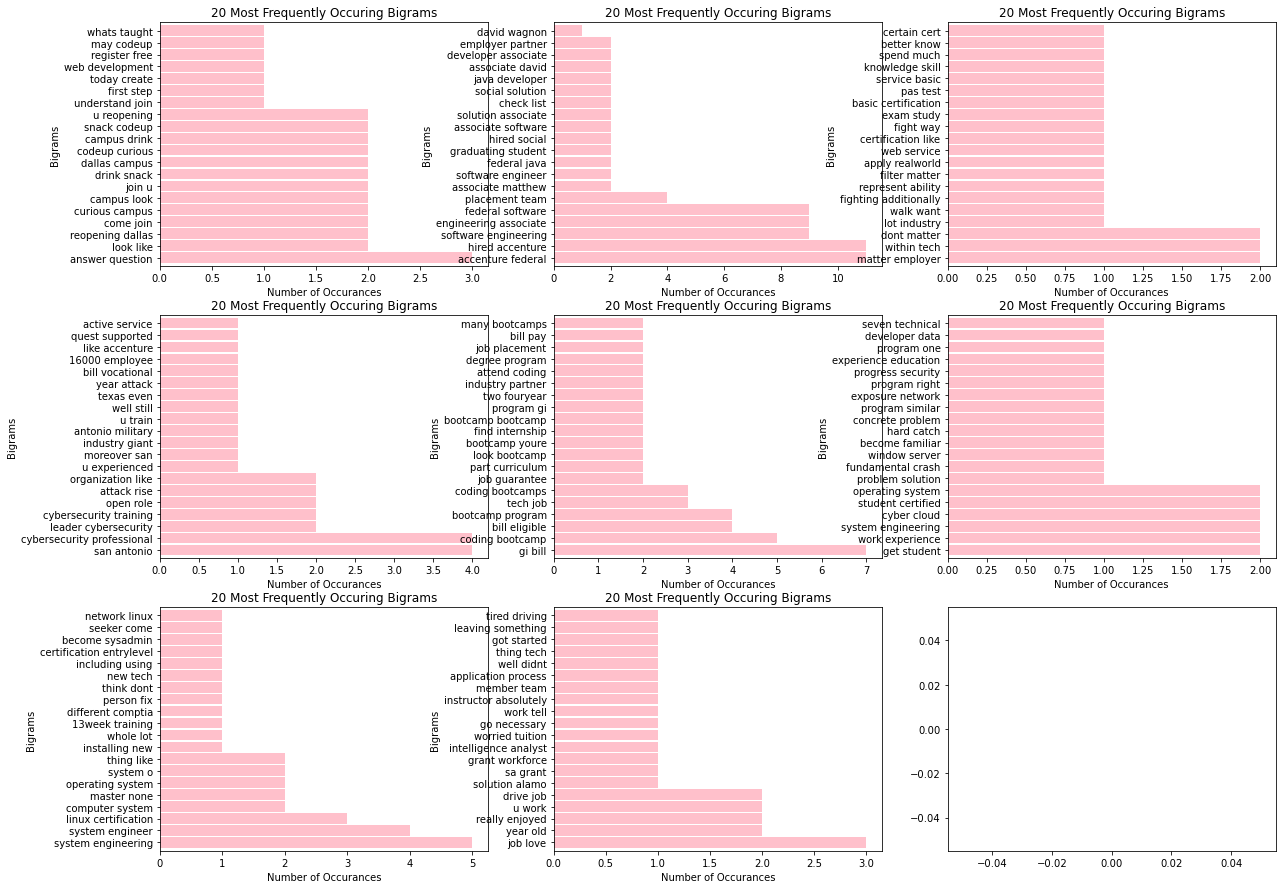

In [28]:
n = 1
for top_20 in top_20_bigrams:
    plt.subplot(5,3,n)
    top_20.plot.barh(color='pink', width=.9, figsize=(20,26))

    plt.title('20 Most Frequently Occuring Bigrams')
    plt.ylabel('Bigrams')
    plt.xlabel('Number of Occurances')
    
    ticks, _ = plt.yticks()
    labels = top_20.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    n += 1